In [1]:
import os

os.chdir('..')

In [2]:
import ast
import json
import pandas as pd

from utils.read_data import read_jsonl
from RE.scripts.settings import MAP_LABELS
from RE.RelationExtractor import RelationExtractor

/opt/conda/envs/spacy_gpu/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import spacy

print('Using GPU: ', spacy.prefer_gpu())

Using GPU:  True


In [4]:
display_syntax = True

### Read data

In [5]:
data_path = './RE/assets/annotations_test.jsonl'

In [6]:
data = read_jsonl(data_path)

In [7]:
data.head()

,text,spans,tokens,relations,answer,meta
0,"additionally, whereas incubation of adipose-ti...","[{'id': 35091, 'text': 'adipose-tissue', 'star...","[{'text': 'additionally', 'start': 0, 'end': 1...","[{'head': 8, 'child': 18, 'head_span': {'start...",accept,{'source': 'unkown'}
1,in comparison to a pressed echinaceae-preparat...,"[{'id': 17727, 'text': 'fec', 'start': 51, 'to...","[{'text': 'in', 'start': 0, 'end': 2, 'id': 0,...","[{'head': 10, 'child': 15, 'head_span': {'star...",accept,{'source': 'unkown'}
2,dna damage and replication stress activate th...,"[{'id': 35408, 'text': 'dna', 'start': 1, 'tok...","[{'text': ' ', 'start': 0, 'end': 1, 'id': 0, ...","[{'head': 2, 'child': 9, 'head_span': {'start'...",accept,{'source': 'unkown'}
3,"when compared to controls, the density of 125i...","[{'id': 35071, 'text': '125i-ngf', 'start': 42...","[{'text': 'when', 'start': 0, 'end': 4, 'id': ...","[{'head': 11, 'child': 21, 'head_span': {'star...",accept,{'source': 'unkown'}
4,we establish that rnf169 binds to ubiquitylate...,"[{'id': 18566, 'text': 'rnf169', 'start': 18, ...","[{'text': 'we', 'start': 0, 'end': 2, 'id': 0,...","[{'head': 4, 'child': 10, 'head_span': {'start...",accept,{'source': 'unkown'}


In [8]:
texts = data.text.values.tolist()

In [9]:
spans = []
for k in range(data.shape[0]):
    x = data.iloc[k]
    spans.append([(x.spans[i]['start'], x.spans[i]['end'], x.spans[i]['label']) for i in range(len(x.spans))])

In [10]:
spans[0]

[(36, 50, 'TISSUE'),
 (93, 121, 'TARGET'),
 (142, 168, 'TARGET'),
 (185, 191, 'TARGET'),
 (326, 345, 'CHEMICAL')]

### Extracted relations by the syntax pipeline

In [11]:
syntax_data = pd.read_csv('./additional_data/syntax_relations_on_test.csv')

In [12]:
syntax_data['relations'] = syntax_data['relations'].apply(lambda x: ast.literal_eval(x))
syntax_data['syntax_relations'] = syntax_data['syntax_relations'].apply(lambda x: ast.literal_eval(x))
syntax_data['spans'] = syntax_data['spans'].apply(lambda x: ast.literal_eval(x))

### Predict

In [13]:
if spacy.prefer_gpu():
    re = RelationExtractor(model='trf')
else:
    re = RelationExtractor(model='tok2vec')

In [14]:
for i in range(len(texts)):
    print('\n\n\n')
    print('Text : ', texts[i])
    print('\nPubMedBERT preds : ')
    _, preds = re.get_predictions(texts[i], threshold=0.4, disable_ner=True, ents=spans[i])
    if display_syntax:
        print('\nSyntax preds : ')
        syntax_preds = syntax_data.iloc[i].syntax_relations
        for p in syntax_preds:
            print('entities: ', (p['effector'], p['effectee']), ' --> predicted relation: ', p['link'].split('!')[-1])





Text :  additionally, whereas incubation of adipose-tissue extracts from fed steers did not activate endogenous glycogen synthase (through a presumed phosphoprotein phosphatase mechanism), the enzyme from starved or re-fed (up to 3 days re-feeding) steers was reversibly activated as measured by changes in the value for the a0.5 for glucose 6-phosphate

PubMedBERT preds : 
spans: [(5, 'adipose-tissue', 'TISSUE'), (15, 'endogenous glycogen synthase', 'TARGET'), (22, 'phosphoprotein phosphatase', 'TARGET'), (28, 'enzyme', 'TARGET'), (59, 'glucose 6-phosphate', 'CHEMICAL')]
entities: ('adipose-tissue', 'endogenous glycogen synthase') --> predicted relation: Activate

Syntax preds : 
entities:  ('adipose-tissue', 'endogenous glycogen synthase')  --> predicted relation:  activate




Text :  in comparison to a pressed echinaceae-preparation, fec activated mouse macrophages secrete interleukin-6 and tumor-necrosis-factor and kill protozoa, fungi and bacteria, with higher efficiency

PubMe

### Evaluate

In [17]:
import numpy as np
import matplotlib.pyplot as plt

from RE.scripts.rel_pipe import get_examples_from_model, score_relations, score_relations_by_label
from RE.scripts.settings import MAP_LABELS

In [20]:
examples = get_examples_from_model('../RE/training_trf/model-best', '../RE/data/test.spacy')

In [21]:
# Check number of examples in the training set by label
train = read_jsonl('../RE/assets/annotations_train.jsonl')
train['relation_labels'] = train['relations'].apply(lambda x: list(set([x[i]['label'] for i in range(len(x))])))
train_explode = train.explode('relation_labels')

In [22]:
labels = [MAP_LABELS[verb] for verb in train_explode['relation_labels'].value_counts().index]

Text(0.5, 1.0, 'Number of sentences by bioverb in the training dataset')

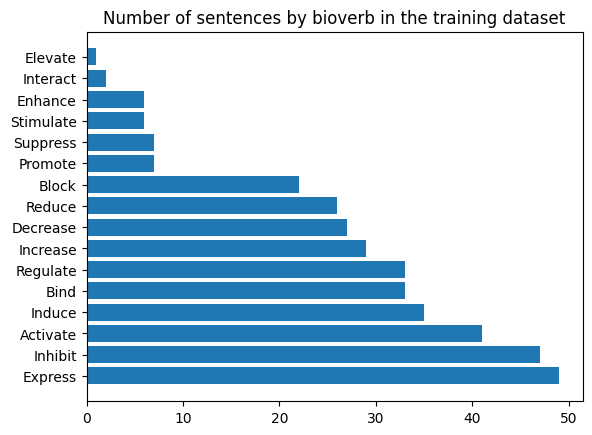

In [23]:
plt.barh(labels, train_explode['relation_labels'].value_counts().values)
plt.title('Number of sentences by bioverb in the training dataset')

In [24]:
print('Score : ',  score_relations(examples, 0.4))
print('\nScores by relation class : ')
scores_by_label = {}
for label in labels:
    scores_by_label[label] = np.round(score_relations_by_label(examples, 0.4, label)["rel_micro_f_" + label], 2)
print(scores_by_label)

Score :  {'rel_micro_p': 0.7087912087912088, 'rel_micro_r': 0.5466101694915254, 'rel_micro_f': 0.6172248803827751}

Scores by relation class : 
{'Express': 0.69, 'Inhibit': 0.91, 'Activate': 0.54, 'Induce': 0.48, 'Bind': 0.8, 'Regulate': 0.93, 'Increase': 0.67, 'Decrease': 0.45, 'Reduce': 0.84, 'Block': 1.0, 'Promote': 0.0, 'Suppress': 0.0, 'Stimulate': 0.0, 'Enhance': 0.0, 'Interact': 0.0, 'Elevate': 0.0}


Text(0.5, 1.0, 'F1-scores by bioverb in the test set')

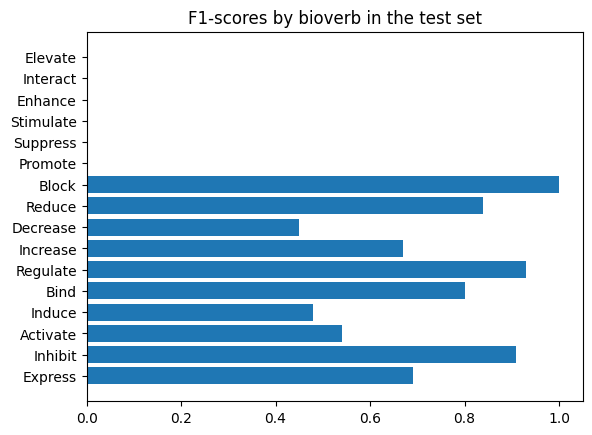

In [25]:
plt.barh(list(scores_by_label.keys()), scores_by_label.values())
plt.title('F1-scores by bioverb in the test set')

### Evaluate syntax model

In [23]:
import numpy as np
from sklearn.metrics import f1_score

In [24]:
syntax_data['truth'] = syntax_data.apply(lambda x: 
                                        [(x.text[x.relations[i]['head_span']['start']: x.relations[i]['head_span']['end']], 
                                         x.text[x.relations[i]['child_span']['start']: x.relations[i]['child_span']['end']], 
                                         x.relations[i]['label']) 
                                        for i in range(len(x.relations))], axis=1)
syntax_data['pred'] = syntax_data.syntax_relations.apply(lambda x: [(x[i]['effector'], 
                                                                    x[i]['effectee'], 
                                                                    x[i]['link'])
                                                                   for i in range(len(x))])

In [25]:
def process_pred(label):
    label = label.replace('!', '')
    label = label.replace('decreased', 'decreas')
    label = label.replace('increase', 'increas')
    label = label.replace('increased', 'increas')
    label = label.replace('blocked', 'block')
    label = label.replace('decreases', 'decreas')
    label = label.replace('increases', 'increas')
    label = label.replace('activd', 'activ')
    label = label.replace('induced', 'induc')
    label = label.replace('enhances', 'enhance')
    label = label.replace('decrease', 'decreas')
    label = label.replace('induce', 'induc')
    label = label.replace('binds', 'bind')
    label = label.replace('regulates', 'regul')
    label = label.replace('activs', 'activ')
    label = label.replace('activate', 'activ')
    label = label.replace('reduced', 'reduc')
    label = label.replace('increasd', 'increas')
    label = label.replace('increass', 'increas')
    label = label.replace('regulate', 'regul')
    label = label.replace('activd', 'activ')
    label = label.replace('activs', 'activ')
    return label

In [26]:
syntax_data['pred'] = syntax_data['pred'].apply(lambda x: [(x[i][0], x[i][1], process_pred(x[i][2]))
                                                          for i in range(len(x))])

In [27]:
# Check if all labels have the same format
pred_labels = syntax_data.pred.apply(lambda x: [x[i][2] for i in range(len(x))])
truth_labels = syntax_data.truth.apply(lambda x: [x[i][2] for i in range(len(x))])

unique_pred_labels = []
for i in range(len(pred_labels)):
    unique_pred_labels += [l for l in pred_labels[i]]
unique_pred_labels = list(set(unique_pred_labels))

unique_truth_labels = []
for i in range(len(truth_labels)):
    unique_truth_labels += [l for l in truth_labels[i]]
unique_truth_labels = list(set(unique_truth_labels))

assert len([l for l in unique_pred_labels if l not in unique_truth_labels]) == 0

In [28]:
def get_y_pred(x):
    truth = x.truth
    pred = x.pred
    y_pred = []
    for c in truth:
        if c in pred:
            y = 1
        else:
            y = 0
        y_pred.append(y)
    for c in pred:
        if c not in truth:
            y_pred.append(1)
    return y_pred + [0] * (len(x.y_truth) - len(y_pred))

In [29]:
syntax_data['y_truth'] = syntax_data.apply(lambda x: [1] * len(x.truth) + [0] * (len(x.spans)*(len(x.spans)-1) - len(x.truth)), 
                                          axis=1)
syntax_data['y_pred'] = syntax_data.apply(lambda x: get_y_pred(x), axis=1)

In [30]:
syntax_data['f1_score'] = syntax_data.apply(lambda x: f1_score(x.y_truth, x.y_pred), axis=1)
print('F-score of the syntax method : ', np.mean(syntax_data.f1_score))

F-score of the syntax method :  0.22474153526785104


##### Use these function to evaluate pubmedbert model

In [31]:
data['formatted_spans'] = spans

In [32]:
all_preds = data.apply(lambda x: re.get_predictions(x.text, 0.4, True, x.formatted_spans), axis=1)

spans: [(5, 'adipose-tissue', 'TISSUE'), (15, 'endogenous glycogen synthase', 'TARGET'), (22, 'phosphoprotein phosphatase', 'TARGET'), (28, 'enzyme', 'TARGET'), (59, 'glucose 6-phosphate', 'CHEMICAL')]
entities: ('adipose-tissue', 'endogenous glycogen synthase') --> predicted relation: Activate
spans: [(9, 'fec', 'CHEMICAL'), (12, 'macrophages', 'TISSUE'), (14, 'interleukin-6', 'TARGET'), (16, 'tumor-necrosis-factor', 'TARGET')]
entities: ('fec', 'macrophages') --> predicted relation: Activate
entities: ('macrophages', 'interleukin-6') --> predicted relation: Express
spans: [(1, 'dna', 'TARGET'), (8, 'chk1', 'TARGET')]
entities: ('dna', 'chk1') --> predicted relation: Activate
spans: [(8, '125i-ngf', 'TARGET'), (20, 'striatum', 'TISSUE'), (24, 'progressive supranuclear palsy', 'DISEASE'), (35, "parkinson's disease", 'DISEASE'), (39, '125i-ngf', 'TARGET'), (49, 'nucleus basalis of meynert', 'TISSUE')]
spans: [(3, 'rnf169', 'TARGET'), (7, 'h2a-lys13', 'TARGET'), (11, 'lys15', 'TARGET'), 

In [33]:
def process_bert_pred(label):
    return [l for l in MAP_LABELS if MAP_LABELS[l]==label][0]

In [34]:
data['pred'] = all_preds
data['pred'] = data['pred'].apply(lambda x: [(x[1][i][0][0], x[1][i][0][1], process_bert_pred(x[1][i][0][2])) 
                                               for i in range(len(x[1]))])

In [35]:
data['truth'] = data.apply(lambda x: 
                                        [(x.text[x.relations[i]['head_span']['start']: x.relations[i]['head_span']['end']], 
                                         x.text[x.relations[i]['child_span']['start']: x.relations[i]['child_span']['end']], 
                                         x.relations[i]['label']) 
                                        for i in range(len(x.relations))], axis=1)

In [36]:
data['y_truth'] = data.apply(lambda x: [1] * len(x.truth) + [0] * (len(x.spans)*(len(x.spans)-1) - len(x.truth)), 
                                          axis=1)
data['y_pred'] = data.apply(lambda x: get_y_pred(x), axis=1)

In [37]:
data['f1_score'] = data.apply(lambda x: f1_score(x.y_truth, x.y_pred), axis=1)
print('F-score of the pubmedBERT method : ', np.mean(data.f1_score))

F-score of the pubmedBERT method :  0.5929665363875889
